# Modelling the data

In [1]:
# Load the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import collections
import seaborn as sns

df = pd.read_csv('../../data/df_main.csv')

In [3]:
df.loc[(df['year'] == 2004) & (df['from_country'] == 'united kingdom')].shape

(23, 27)

## XGBoost to predict if score given

First step in the hurdle model.

Example: https://www.kaggle.com/code/sriharinitumu/light-gbm-with-hurdle-modelling


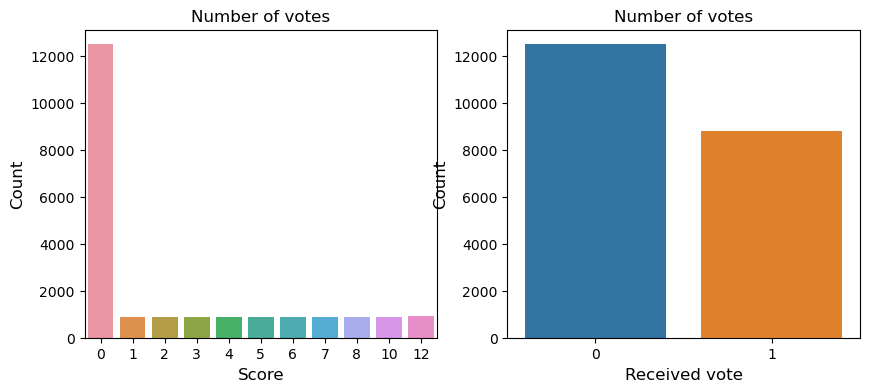

In [6]:
df['received_vote'] = df['points'].apply(lambda x: 1 if x > 0 else 0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


# Bar chart for vote occurrences
sns.countplot(x="points", data=df, ax=ax1)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xlabel('Score', fontsize=12)
ax1.set_title('Number of votes', fontsize=12)

sns.countplot(x="received_vote", data=df, ax=ax2)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_xlabel('Received vote', fontsize=12)
ax2.set_title('Number of votes', fontsize=12)

plt.show()

As you can see we have a lot of zeroes....this probably makes this problem appropriate for a hurdle model. Where we first decide if a score is given, and then if it is, we predict the score.

In [7]:
df.columns

Index(['year', 'Artist', 'from_country', 'to_country', 'points',
       'total_points', 'rank', 'from_code2', 'from_code3', 'to_code2',
       'to_code3', 'Official_languages', 'Language_sung', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'gender',
       'migration_v2p', 'population_p', 'prop_emigrants_v2p', 'migration_p2v',
       'population_v', 'prop_emigrants_p2v', 'migration_pop_year',
       'comps_since_last_win', 'received_vote'],
      dtype='object')

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_57484/1087869506.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost['prop_emigrants_v2p'] = df_xgboost['prop_emigrants_v2p'].apply(lambda x: np.log10(x+4e-8))
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_57484/1087869506.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost['prop_emigrants_p2v'] = df_xgboost['prop_emigrants_p2v'].apply(lambda x: np.log10(x+4e-8))
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/i

<AxesSubplot:>

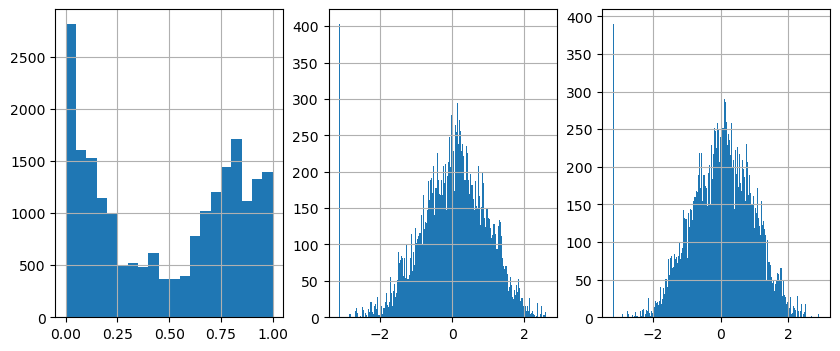

In [16]:
# scale some of the features

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


df_xgboost = df[['year', 'from_country', 'points', 'to_code2',
        'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'gender',
       'prop_emigrants_v2p',  'prop_emigrants_p2v',
       'comps_since_last_win', 'received_vote']]

#df_xgboost['has_border'] = df_xgboost['has_border'].fillna(0)

# log10 scale the prop_emigrants column
df_xgboost['prop_emigrants_v2p'] = df_xgboost['prop_emigrants_v2p'].apply(lambda x: np.log10(x+4e-8))
df_xgboost['prop_emigrants_p2v'] = df_xgboost['prop_emigrants_p2v'].apply(lambda x: np.log10(x+4e-8))


# apply the standard scaler to prop_emigrants and comps_since_last_win
scaler = StandardScaler()
df_xgboost[['prop_emigrants_v2p']] = scaler.fit_transform(df_xgboost[['prop_emigrants_v2p']])
df_xgboost[['prop_emigrants_p2v']] = scaler.fit_transform(df_xgboost[['prop_emigrants_p2v']])

scaler = MinMaxScaler()
df_xgboost[['comps_since_last_win']] = scaler.fit_transform(df_xgboost[['comps_since_last_win']])


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

# histogram of the log scaled prop_emigrants column
df_xgboost['comps_since_last_win'].hist(bins=20, ax=ax1)
df_xgboost['prop_emigrants_v2p'].hist(bins=200, ax=ax2)
df_xgboost['prop_emigrants_p2v'].hist(bins=200, ax=ax3)

In [17]:
df_xgboost

,year,from_country,points,to_code2,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,gender,prop_emigrants_v2p,prop_emigrants_p2v,comps_since_last_win,received_vote
0,1998,belgium,5,HR,False,True,False,1,True,female,-0.459294,-1.228039,0.646154,1
1,1998,belgium,2,CY,False,True,False,1,True,male,-0.123958,-1.202616,0.646154,1
2,1998,belgium,0,EE,False,True,False,1,True,male,-3.141613,-1.316419,0.646154,0
3,1998,belgium,0,MK,False,True,False,1,True,male,NaN,-1.034414,0.646154,0
4,1998,belgium,0,FI,False,True,False,1,True,group,-0.632590,-0.063750,0.646154,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21305,2022,united kingdom,0,RS,False,True,False,1,True,female,-0.166780,-0.097066,0.200000,0
21306,2022,united kingdom,8,ES,True,True,True,2,True,female,1.442065,0.961955,0.784615,1
21307,2022,united kingdom,10,SE,True,False,False,1,False,female,1.135240,0.414530,0.076923,1
21308,2022,united kingdom,0,CH,True,False,False,1,False,male,1.371268,0.256435,0.492308,0


In [22]:

from numpy import loadtxt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def basic_xgboost(df_input, seed, test_size, predictor_column='received_vote'):
    X = df_input[['year', 'from_country', 'to_code2', 'points',
        'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'gender',
       'prop_emigrants_v2p',  'prop_emigrants_p2v',
       'comps_since_last_win', "received_vote"]]



    Y = df_input[predictor_column]


    # one hot encode the gender, from country and code
    for j in ['gender', 'from_country', 'to_code2']:
        j_text = '_voting' if j == 'from_country' else ''
        for i in X[j].unique():
            output_binary = X[j].apply(lambda x: 1 if x == i else 0)
            X[i+j_text] = output_binary

        X = X[X.columns.drop(j)]

    # convert Y to int
    Y = Y.astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed, stratify=X['points'])

    test_all = X_test

    # remove 'Votes' and 'received_vote' columns from X_train
    X_train = X_train[X_train.columns.drop('points')]
    X_train = X_train[X_train.columns.drop('received_vote')]
    X_test = X_test[X_test.columns.drop('points')]
    X_test = X_test[X_test.columns.drop('received_vote')]

    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)

    return model, X_test, y_test, test_all

def model_predictions(model, X_test, y_test):
    Xt = X_test.copy()
    y_pred = model.predict(Xt)
    predictions = [round(value) for value in y_pred]

    Xt['predictions'] = predictions
    Xt['actual'] = y_test

    return Xt

def model_evalutation(df_pred):
    # evaluate predictions
    accuracy = accuracy_score(df_pred['actual'], df_pred['predictions'])
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    # print a confusion matrix heatmap

    cm = confusion_matrix(df_pred['actual'], df_pred['predictions'])
    sns.heatmap(cm, annot=True, fmt="d")

    # add title and axis labels
    plt.title('Confusion matrix' + "(Accuracy={:.3f})".format(accuracy))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_57484/1387931111.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i+j_text] = output_binary
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_57484/1387931111.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i+j_text] = output_binary
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_57484/1387931111.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Accuracy: 75.49%


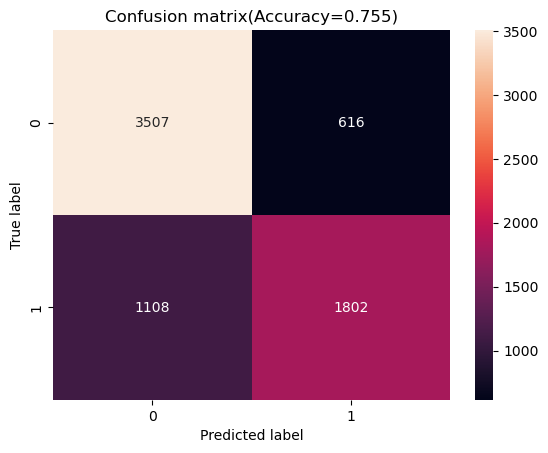

In [25]:
model_basic, X_test, y_test, test_all = basic_xgboost(df_xgboost, seed=7, test_size=0.33)
predictions = model_predictions(model_basic, X_test, y_test)
model_evalutation(predictions)

<AxesSubplot:>

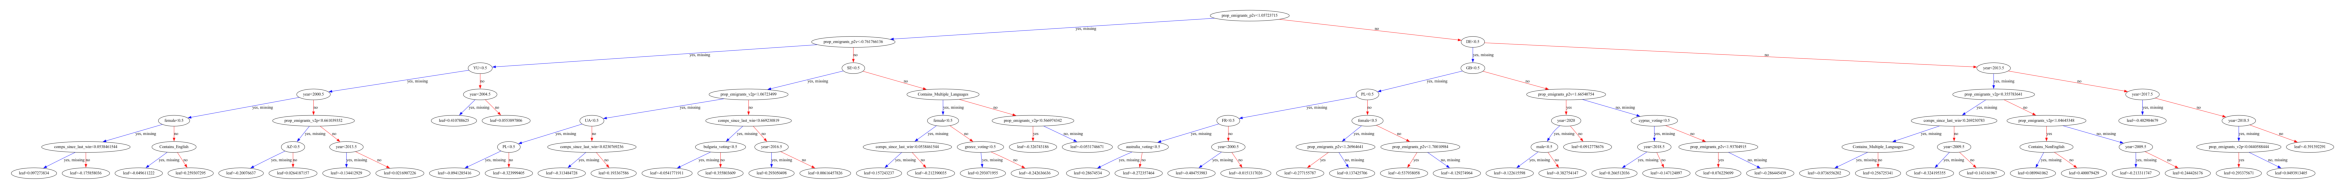

In [26]:
import matplotlib
import xgboost as xgb

graph = xgb.to_graphviz(model_basic, num_trees=1, rankdir='LR')

fig, ax = plt.subplots(figsize=(30, 50))
xgb.plot_tree(model_basic, num_trees=1, ax=ax)

## Ranking Scores

So of those, lets subset to only those with a score

In [27]:
test_all.head()

,year,points,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,prop_emigrants_v2p,prop_emigrants_p2v,comps_since_last_win,...,BY,BG,GE,RS,AZ,IT,ME,SM,AU,CZ
10585,2011,0,True,True,True,2,True,-0.399532,-0.866897,0.076923,...,0,0,0,0,0,0,0,0,0,0
1958,2001,0,False,True,False,1,True,-0.644757,-0.049910,0.692308,...,0,0,0,0,0,0,0,0,0,0
9579,2010,10,True,False,False,1,False,-0.571965,0.229081,0.353846,...,0,0,0,0,0,0,0,0,0,0
2178,2002,8,True,False,False,1,True,-0.017305,-1.118413,0.707692,...,0,0,0,0,0,0,0,0,0,0
1776,2001,0,False,True,False,1,True,1.287103,-0.190789,0.030769,...,0,0,0,0,0,0,0,0,0,0


In [28]:
import xgboost as xgb
from scipy.stats import rankdata
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from scipy.stats import spearmanr
import numpy as np


def xgboost_rank_model(df_input, test_size=0.33, seed=7):

    df2 = df_input[['year', 'from_country', 'to_code2', 'points',
        'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'gender',
       'prop_emigrants_v2p',  'prop_emigrants_p2v',
       'comps_since_last_win']]

    #df2 = df2.loc[df2['Votes'] > 0]

    #df2['has_border'] = df2['has_border'].fillna(0)
    df2 = df2.rename(columns={"points": 'rank'})
    #df2 = df2.rename(columns={"From country": 'id'})

    df2['rank'] = df2['rank'].astype(int) - 1

    df2['id'] = df2['from_country'].astype(str) + df2['year'].astype(str)

    # one hot encode the gender, from country and code
    for j in ['gender', 'to_code2', 'from_country']:
        j_text = "_voting" if j == 'from_country' else ''
        for i in df2[j].unique():
            df2[i+j_text] = df2[j].apply(lambda x: 1 if x == i else 0)

        df2 = df2[df2.columns.drop(j)]

    #df2= df2[df2.columns.drop('From country')]
    df2= df2[df2.columns.drop('year')]

    gss = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state = seed).split(df2, groups=df2['id'])

    X_train_inds, X_test_inds = next(gss)

    train_data= df2.iloc[X_train_inds]
    X_train = train_data.loc[:, ~train_data.columns.isin(['id','rank'])]
    y_train = train_data.loc[:, train_data.columns.isin(['rank'])]

    groups = train_data.groupby('id').size().to_frame('size')['size'].to_numpy()

    test_data= df2.iloc[X_test_inds]
    test_data = test_data[X_train.columns.tolist() + ['rank', 'id']]

    #We need to keep the id for later predictions
    # X_test = test_data.loc[:, ~test_data.columns.isin(['rank'])]
    # y_test = test_data.loc[:, test_data.columns.isin(['rank'])]

    model = xgb.XGBRanker(  
        tree_method='hist',
        booster='gbtree',
        objective='rank:pairwise',
        random_state=7, 
        learning_rate=0.1,
        colsample_bytree=0.9, 
        eta=0.05, 
        max_depth=6, 
        n_estimators=110, 
        subsample=0.75 
    )

    model.fit(X_train, y_train, group=groups, verbose=True)

    return model, test_data, train_data

 

def ranked_model_predictions(model, test_set):
    test = test_set.copy()
    
    test['prediction_rel'] = np.nan
    test['predictions'] = np.nan

    for i in test['id'].unique():
        sub_test = test.loc[test['id'] == i, ~test.columns.isin(['id', 'rank', 'prediction_rel', 'predictions'])]

        preds = model.predict(sub_test)

        # get the order of the predictions 
        res = rankdata(preds, method='ordinal')
        test.loc[test['id'] == i, 'prediction_rel'] = res

        # create a score for top 10 predictions getting 1:10 and others 0
        top10 = test.loc[test['id'] == i, 'prediction_rel'].nlargest(10).values


        test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'prediction_rel'].apply(lambda x: x if x in top10 else 0)
        
        # if not zero subtract min(top10) 
        test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: x - max(top10) + 10 if x != 0 else 0)

        # if 10 set to 12
        test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: 12 if x == 10 else x)
        test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: 10 if x == 9 else x)

    test['actual'] = test['rank'] + 1


    accuracy = accuracy_score(test['actual'], test['predictions'])
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    return test

In [30]:


model_ranked, test_data, train_data = xgboost_rank_model(df_xgboost.loc[df_xgboost['points'] > 0], seed=7, test_size=0.33)
out = ranked_model_predictions(model_ranked, test_data)



Accuracy: 14.59%


In [31]:
out['predictions'].value_counts()

8.0     288
6.0     288
5.0     288
1.0     288
2.0     288
4.0     288
3.0     288
12.0    288
10.0    288
7.0     288
0.0      26
Name: predictions, dtype: int64

### Plots

In [32]:
def violins(pred):
    prediction_df = pred.copy()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7)) 

    if(max(prediction_df['actual']) < 12):        
        prediction_df['predictions'] = prediction_df['predictions'] + 1
        prediction_df['actual'] = prediction_df['actual'] + 1
        prediction_df['predictions'] = prediction_df['predictions'].apply(lambda x: 12 if x == 10 else x)
        prediction_df['predictions'] = prediction_df['predictions'].apply(lambda x: 10 if x == 9 else x)
        prediction_df['actual'] = prediction_df['actual'].apply(lambda x: 12 if x == 10 else x)
        prediction_df['actual'] = prediction_df['actual'].apply(lambda x: 10 if x == 9 else x)

    # violin plot of predictions for each rank
    sns.violinplot(x="actual", y="predictions", data=prediction_df, order=range(0, 13), ax=ax1)
    sns.violinplot(y="actual", x="predictions", data=prediction_df, order=range(0, 13), ax=ax2)

    # add a best fit line - scale is wrong because numeric on top of categorical
    sns.regplot(x="actual", y="predictions", data=prediction_df, scatter=False, color='black', ax=ax1)
    sns.regplot(y="actual", x="predictions", data=prediction_df, scatter=False, color='black', ax=ax2)


    # spearman correlation
    corr, _ = spearmanr(prediction_df['actual'], prediction_df['predictions'])

    fig.suptitle('Predicted Score vs Actual Score (r = ' + str(round(corr, 4)) + ')', fontsize=15)

    # set x label
    ax1.set_xlabel('Actual Score')
    ax1.set_ylabel('Predicted Score')
    ax2.set_ylabel('Actual Score')
    ax2.set_xlabel('Predicted Score')

def cm_heatmap (prediction_df, title='Confusion matrix', ax=None):
    cm = confusion_matrix(prediction_df['actual'], prediction_df['predictions'])

    plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax, vmin=0, vmax=100)

    if(len(cm[[0]][0]) == 11) : 
    # change the tick labels
        plot.set_xticks(np.arange(0, 11, 1)+0.5, np.arange(0, 9, 1).tolist() + [10, 12])
        plot.set_yticks(np.arange(0, 11, 1)+0.5, np.arange(0, 9, 1).tolist() + [10, 12])
    else: 
        plot.set_xticks(np.arange(0, 10, 1)+0.5, np.arange(1, 9, 1).tolist() + [10, 12])
        plot.set_yticks(np.arange(0, 10, 1)+0.5, np.arange(1, 9, 1).tolist() + [10, 12])

    plot.set_title(title)
    plot.set_ylabel('Actual Score')
    plot.set_xlabel('Predicted Score')

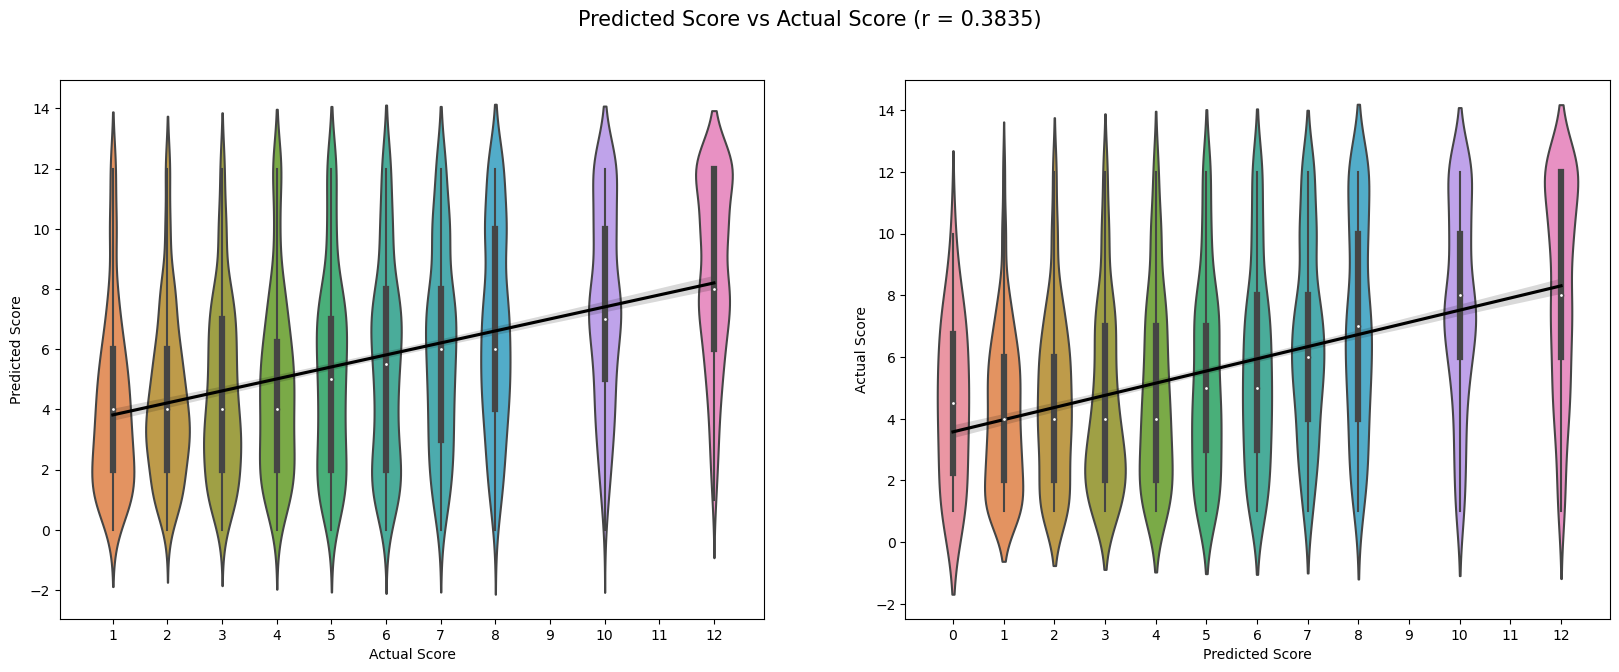

In [33]:
violins(out)

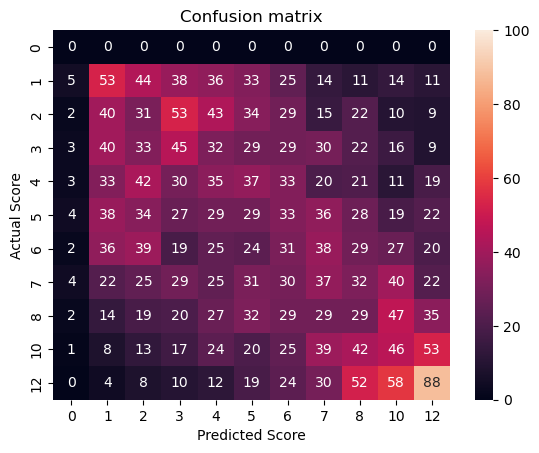

In [34]:
cm_heatmap(out)

See [here](https://discuss.xgboost.ai/t/evaluating-xgboost-ranking/959/2) for description of prediction scores

The 0 predictions are coming up when we have more that 10 non-zeroes (due to draws). So this actually works quite well I think.

### Quickly see how this compares to a non pairwise rank model


/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_57484/1277101257.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_votes['Votes2'] = df_votes["points"] - 1
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_57484/1277101257.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_votes['Votes2'] = df_votes['Votes2'].apply(lambda x: 8 if x == 9 else x)
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_57484/1277101257.py:5: SettingWithCopyWarning: 
A value is trying to be set o

Accuracy: 14.02%


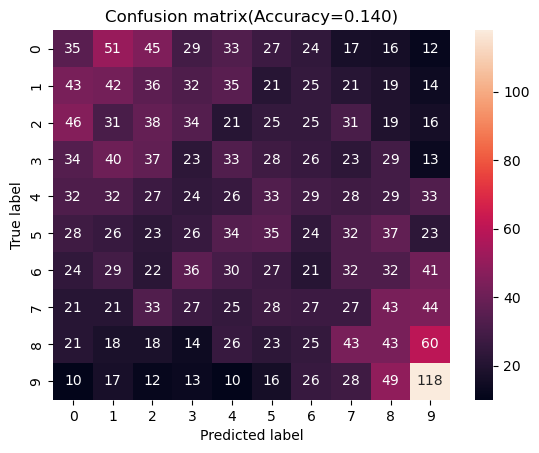

In [37]:
df_votes = df_xgboost.loc[df_xgboost['points'] > 0]

df_votes['Votes2'] = df_votes["points"] - 1
df_votes['Votes2'] = df_votes['Votes2'].apply(lambda x: 8 if x == 9 else x)
df_votes['Votes2'] = df_votes['Votes2'].apply(lambda x: 9 if x == 11 else x)

model, X_test, y_test, t2 = basic_xgboost(df_votes, seed=7, test_size=0.33, predictor_column='Votes2')
predictions = model_predictions(model, X_test, y_test)
model_evalutation(predictions)

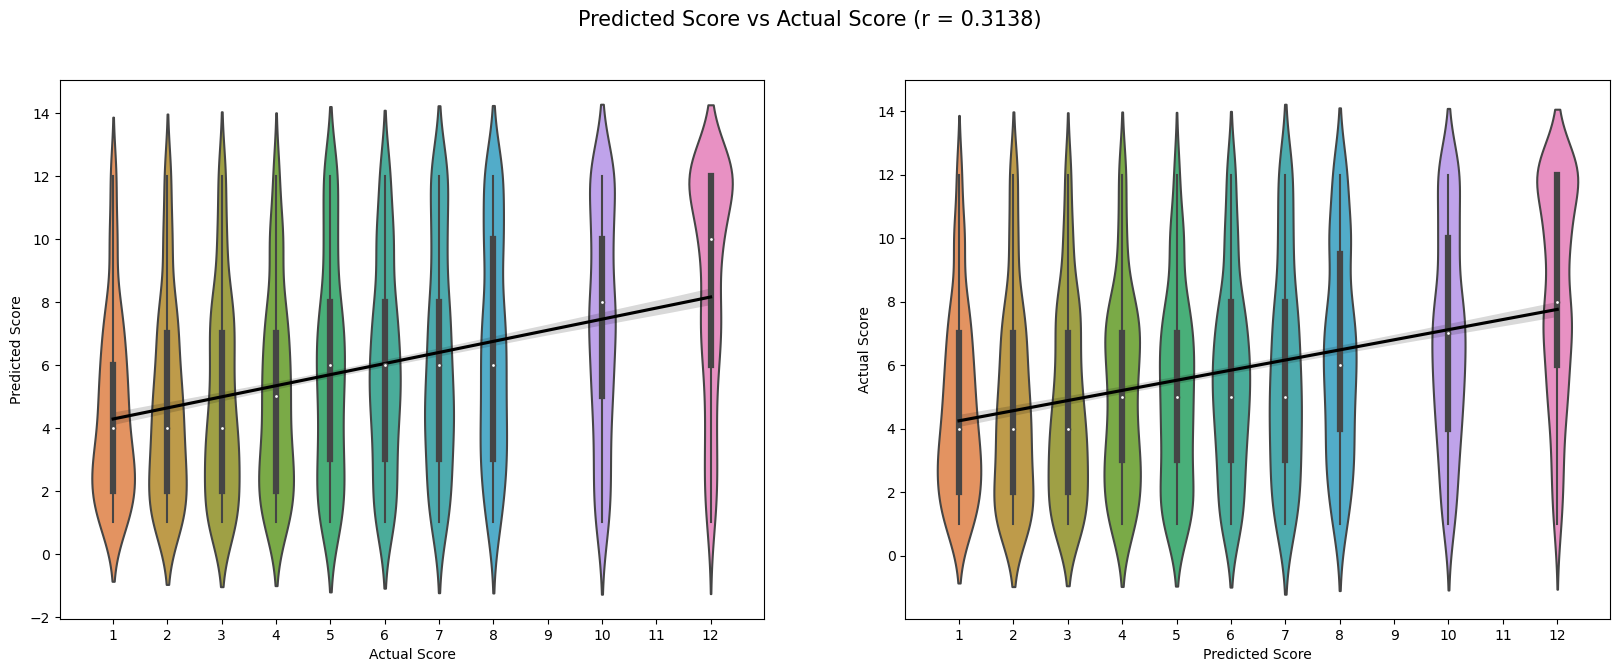

In [38]:
violins(predictions)

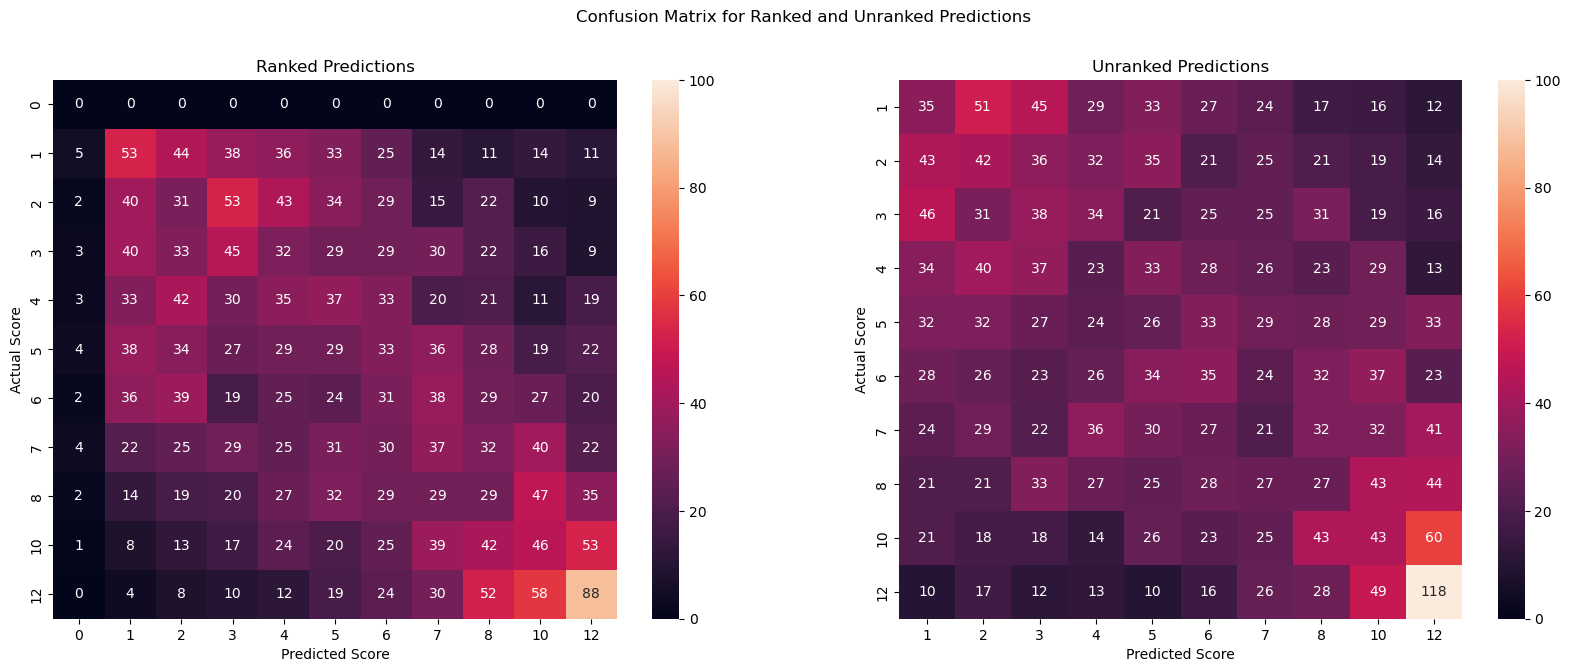

In [39]:
# ranked and unranked plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Confusion Matrix for Ranked and Unranked Predictions')

# ranked plot
cm_heatmap(out, title='Ranked Predictions', ax=ax1)
cm_heatmap(predictions, title='Unranked Predictions', ax=ax2)

# Combine the hurdles

In [40]:
df_xgboost.head()

,year,from_country,points,to_code2,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,gender,prop_emigrants_v2p,prop_emigrants_p2v,comps_since_last_win,received_vote
0,1998,belgium,5,HR,False,True,False,1,True,female,-0.459294,-1.228039,0.646154,1
1,1998,belgium,2,CY,False,True,False,1,True,male,-0.123958,-1.202616,0.646154,1
2,1998,belgium,0,EE,False,True,False,1,True,male,-3.141613,-1.316419,0.646154,0
3,1998,belgium,0,MK,False,True,False,1,True,male,NaN,-1.034414,0.646154,0
4,1998,belgium,0,FI,False,True,False,1,True,group,-0.632590,-0.063750,0.646154,0


In [41]:
df_xgboost['id'] = df_xgboost['from_country'] + df_xgboost['year'].astype(str)

df_xgboost['rank'] = df_xgboost['points']

df_xgboost['rank'] = df_xgboost['rank'].apply(lambda x: 9 if x == 10 else x)
df_xgboost['rank'] = df_xgboost['rank'].apply(lambda x: 10 if x == 12 else x)

#df_xgboost['rank'].value_counts()
df_xgboost['rank'] = df_xgboost['rank'].astype(int)

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_57484/480534090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost['id'] = df_xgboost['from_country'] + df_xgboost['year'].astype(str)
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_57484/480534090.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost['rank'] = df_xgboost['points']
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_57484/480534090.py:5: SettingWithCopyWarning: 
A value is trying to be set on 

In [42]:
df_hurdle = df_xgboost.copy()

#df_hurdle['has_border'] = df_hurdle['has_border'].fillna(0)

df_hurdle.head()


,year,from_country,points,to_code2,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,gender,prop_emigrants_v2p,prop_emigrants_p2v,comps_since_last_win,received_vote,id,rank
0,1998,belgium,5,HR,False,True,False,1,True,female,-0.459294,-1.228039,0.646154,1,belgium1998,5
1,1998,belgium,2,CY,False,True,False,1,True,male,-0.123958,-1.202616,0.646154,1,belgium1998,2
2,1998,belgium,0,EE,False,True,False,1,True,male,-3.141613,-1.316419,0.646154,0,belgium1998,0
3,1998,belgium,0,MK,False,True,False,1,True,male,NaN,-1.034414,0.646154,0,belgium1998,0
4,1998,belgium,0,FI,False,True,False,1,True,group,-0.632590,-0.063750,0.646154,0,belgium1998,0


In [43]:
# one hot encode the gender, from country and code
for j in ['gender', 'to_code2', 'from_country']:
    j_text = "_voting" if j == 'from_ountry' else ''
    for i in df_hurdle[j].unique():
        df_hurdle[i+j_text] = df_hurdle[j].apply(lambda x: 1 if x == i else 0)

    df_hurdle = df_hurdle[df_hurdle.columns.drop(j)]

#df2= df2[df2.columns.drop('From country')]
df_hurdle= df_hurdle[df_hurdle.columns.drop('year')]

df_hurdle.head()

,points,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,prop_emigrants_v2p,prop_emigrants_p2v,comps_since_last_win,received_vote,...,"moldova, republic of",armenia,czechia,georgia,montenegro,serbia,azerbaijan,san marino,italy,australia
0,5,False,True,False,1,True,-0.459294,-1.228039,0.646154,1,...,0,0,0,0,0,0,0,0,0,0
1,2,False,True,False,1,True,-0.123958,-1.202616,0.646154,1,...,0,0,0,0,0,0,0,0,0,0
2,0,False,True,False,1,True,-3.141613,-1.316419,0.646154,0,...,0,0,0,0,0,0,0,0,0,0
3,0,False,True,False,1,True,NaN,-1.034414,0.646154,0,...,0,0,0,0,0,0,0,0,0,0
4,0,False,True,False,1,True,-0.632590,-0.063750,0.646154,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split

# select a random sample of 33% of the unique values of df_hurdle['id']
test_groups = np.random.choice(df_hurdle['id'].unique(), size=int(len(df_hurdle['id'].unique())*0.33), replace=False)
train_groups = np.setdiff1d(df_hurdle['id'].unique(), test_groups)

train_data = df_hurdle.loc[df_hurdle['id'].isin(train_groups)]
test_data = df_hurdle.loc[df_hurdle['id'].isin(test_groups)]

X_train = train_data.loc[:, ~train_data.columns.isin(['id','rank', 'points', 'received_vote'])]
y_train = train_data.loc[:, train_data.columns.isin(['received_vote'])]

X_test = test_data.loc[:, ~test_data.columns.isin(['id','rank', 'points', 'received_vote'])]
y_test = test_data.loc[:, test_data.columns.isin(['received_vote'])]


In [45]:
model = xgb.XGBClassifier()
hurdle1_model = model.fit(X_train, y_train)

In [47]:
hurdle1_df = model_predictions(hurdle1_model, X_test,  y_test)

# merge test_data and hurdle1_df
cols = [i for i in test_data.columns if i not in hurdle1_df.columns]
hurdle1_df = pd.merge(hurdle1_df, test_data[cols], left_index=True, right_index=True)

hurdle1_df.head()

,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,prop_emigrants_v2p,prop_emigrants_p2v,comps_since_last_win,female,male,...,azerbaijan,san marino,italy,australia,predictions,actual,points,received_vote,id,rank
0,False,True,False,1,True,-0.459294,-1.228039,0.646154,1,0,...,0,0,0,0,1,1,5,1,belgium1998,5
1,False,True,False,1,True,-0.123958,-1.202616,0.646154,0,1,...,0,0,0,0,0,1,2,1,belgium1998,2
2,False,True,False,1,True,-3.141613,-1.316419,0.646154,0,1,...,0,0,0,0,1,0,0,0,belgium1998,0
3,False,True,False,1,True,NaN,-1.034414,0.646154,0,1,...,0,0,0,0,0,0,0,0,belgium1998,0
4,False,True,False,1,True,-0.632590,-0.063750,0.646154,0,0,...,0,0,0,0,0,0,0,0,belgium1998,0


Accuracy: 74.44%


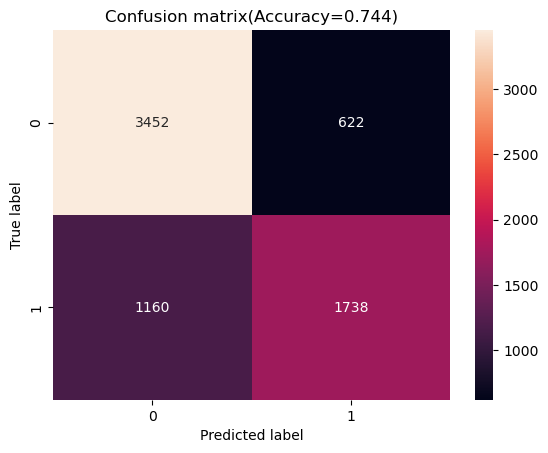

In [49]:
model_evalutation(hurdle1_df)

In [50]:
df2 = hurdle1_df.loc[hurdle1_df['predictions'] > 0]

# remove predictions, actual and received_vote columns
df2 = df2[df2.columns.drop(['predictions', 'actual', "points", 'received_vote'])]

print(df2['rank'].value_counts())

#df2 = df2.rename(columns={"Votes": 'rank'})
#df2 = df2.rename(columns={"From country": 'id'})

#df2['rank'] = df2['rank'].astype(int) - 1


# select a random sample of 33% of the unique values of df_hurdle['id']
test_groups = np.random.choice(df2['id'].unique(), size=int(len(df2['id'].unique())*0.33), replace=False)
train_groups = np.setdiff1d(df2['id'].unique(), test_groups)

train_data = df2.loc[df2['id'].isin(train_groups)]
test_data = df2.loc[df2['id'].isin(test_groups)]

X_train = train_data.loc[:, ~train_data.columns.isin(['id','rank', 'points', 'received_vote'])]
y_train = train_data.loc[:, train_data.columns.isin(['rank'])]

X_test = test_data.loc[:, ~test_data.columns.isin(['id','rank', 'points', 'received_vote'])]
y_test = test_data.loc[:, test_data.columns.isin(['rank'])]

print(test_data['id'].value_counts())
print(train_data['id'].value_counts())

groups = train_data.groupby('id').size().to_frame('size')['size'].to_numpy()

model_ranked = xgb.XGBRanker(  
    tree_method='hist',
    booster='gbtree',
    objective='rank:pairwise',
    random_state=7, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
)

model_ranked.fit(X_train, y_train, group=groups, verbose=True)

0     622
10    260
9     228
8     219
7     205
6     167
5     159
3     144
4     138
2     110
1     108
Name: rank, dtype: int64
denmark2022        14
austria2007        13
netherlands2022    12
france2022         12
lithuania2001      11
                   ..
norway2003          5
belgium2009         5
denmark2016         5
greece2011          5
romania2000         4
Name: id, Length: 94, dtype: int64
sweden2022            13
australia2019         13
united kingdom2000    12
spain2017             12
italy2013             12
                      ..
sweden2016             4
estonia2003            4
croatia2009            4
albania2010            4
finland2006            3
Name: id, Length: 193, dtype: int64


XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.9,
          early_stopping_rounds=None, enable_categorical=False, eta=0.05,
          eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, n_estimators=110, n_jobs=None,
          num_parallel_tree=None, predictor=None, ...)

In [51]:
from scipy.stats import rankdata
from sklearn.metrics import accuracy_score

test = test_data.copy()

test['prediction_rel'] = np.nan
test['predictions'] = np.nan

for i in test['id'].unique():
    sub_test = test.loc[test['id'] == i, ~test.columns.isin(['id', 'rank', 'prediction_rel', 'predictions'])]

    preds = model.predict(sub_test)

    # get the order of the predictions 
    res = rankdata(preds, method='ordinal')
    test.loc[test['id'] == i, 'prediction_rel'] = res

    # create a score for top 10 predictions getting 1:10 and others 0
    top10 = test.loc[test['id'] == i, 'prediction_rel'].nlargest(10).values


    test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'prediction_rel'].apply(lambda x: x if x in top10 else 0)
    
    # if not zero subtract min(top10) 
    test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: x - max(top10) + 10 if x != 0 else 0)

    # if 10 set to 12
    #test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: 12 if x == 10 else x)
    #test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: 10 if x == 9 else x)

test['actual'] = test['rank'] 


accuracy = accuracy_score(test['actual'], test['predictions'])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

predictions2 = test

Accuracy: 8.66%


In [52]:
predictions2['actual'].value_counts()

0     194
10     90
9      71
8      71
7      67
5      52
6      50
3      49
4      41
2      36
1      30
Name: actual, dtype: int64

In [55]:
p1.columns

Index(['Contains_English', 'Contains_NonEnglish',
       'Contains_Multiple_Languages', 'Number_of_Languages',
       'Contains_Own_Language', 'prop_emigrants_v2p', 'prop_emigrants_p2v',
       'comps_since_last_win', 'female', 'male',
       ...
       'azerbaijan', 'san marino', 'italy', 'australia', 'predictions',
       'actual', 'points', 'received_vote', 'id', 'rank'],
      dtype='object', length=113)

In [54]:
p1 = hurdle1_df.copy()


cols = [col for col in p1.columns if '_voting' in col]
cols2 = [col for col in p1.columns if '_voting' not in col]


# wide format _voting columns to long format
hurdle_input2 = pd.melt(p1, id_vars=cols2, 
                       value_vars= cols, var_name='from_country')

hurdle_input2 = hurdle_input2.loc[hurdle_input2['value'] ==1]


p1['from_country'] = hurdle_input2['from_country'].str.replace('_voting', '').tolist()
p1 = p1.drop(cols, axis=1)


cols2 = ['year', 'from_country','received_vote', 'to_code2', 'points', 'rank',
        'Contains_English', 'id'
        # 'has_border',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'gender',
       'prop_emigrants_v2p',  'prop_emigrants_p2v',
       'comps_since_last_win',# 'group', 'female', 'male', 
       'predictions', 'actual']



cols = [col for col in p1.columns if col not in cols2]


hurdle_input4 = pd.melt(p1, id_vars=cols2, 
                       value_vars= cols, var_name='to_code2')

hurdle_input4 = hurdle_input4.loc[hurdle_input4['value'] == 1]

# add hurdle_input2['From country'] to hurdle_input

p1['to_code2'] = hurdle_input4['to_code2'].tolist()

predictions1 = p1


ValueError: Length of values (0) does not match length of index (6972)